In [1]:
#from vqls import *
from utils import *


T dim 10
x_dim 9


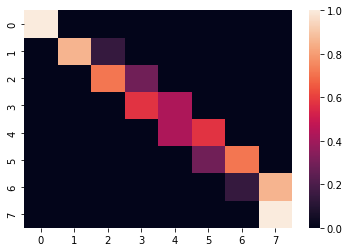

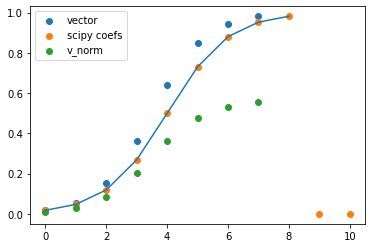

Condition number
 62.475138845718426
norm(yk) 1.77256959808715


In [2]:
lower = 0.
upper = 1. 
n_step = 8
f_i = 0.0  
MAX_ITER = 30

nq=3
# K = 2^n = dim(T)-2
# with dim(S) = KxK
# n = num qubits
# T = set of knots

scaled=False

label = 'sigmoid'
func = sigmoid_t


x = np.arange(lower, upper + .03, (upper-lower)/n_step).tolist() 
xx = np.linspace(lower, upper, n_step) ##inputs sampling in the interval 0,1
y = [func(value,f_i) for value in x]

if scaled:
  norm = np.linalg.norm(y)
  y = y / norm
tck=splrep(x,y,k=1) #coeffs
#plt.scatter(range(len(tck[1])),tck[0], label = "scipy knots")


#############################################################################################
###################################### System Preparation ###################################
#############################################################################################

matrix,vector,v_norm = GeneralizedVQS_System(n_step,label,x,xx,scaled=scaled);

import seaborn as sns

sns.heatmap(matrix)
plt.show()
plt.plot(y)

plt.scatter(range(len(vector)), vector, label="vector")
plt.scatter(range(len(tck[1])),tck[1], label="scipy coefs")
plt.scatter(range(len(v_norm)), v_norm, label="v_norm")
plt.legend()
plt.show()
#############################################################################################
################################# VQLS and Linear Prob. Solving #############################
#############################################################################################

k_numb=np.linalg.cond(np.array(matrix))
print('Condition number\n',k_numb)
print('norm(yk)',np.linalg.norm(vector))




## oskd


In [58]:


import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from math import pi,exp
import pandas as pd
import scipy
from scipy.optimize import minimize


#print(qml.__version__)

class VQLS:
    def __init__(self,matrix,vector, n_qubits,opt ="COBYLA", seed = 42):
        self.matrix = matrix
        self.vector = vector
        self.n_qubits = n_qubits
        self.tot_qubits = n_qubits + 1  
        self.ancilla_idx = n_qubits  
        self.q_delta = 0.01
        self.n_shots = 512#10 ** 6
        self.rng_seed = 0 
        self.iterations = 0
        self.opt = opt
        self.cost_vals = []

    # circuit, and his adjoint, to prepare the state |b> = |yk> from b = yk = v_norm 
    def U_b(self, adjoint=False):
        lines=[e for e in range(self.n_qubits)]
        
        if adjoint:
            qml.adjoint(qml.templates.state_preparations.MottonenStatePreparation)(self.vector,wires=lines)
        else:
            qml.templates.state_preparations.MottonenStatePreparation(self.vector,wires=lines)

    def U_b_full(self, adjoint=False):
        lines=[e for e in range(self.n_qubits)]
        if adjoint:
            qml.adjoint(qml.templates.state_preparations.MottonenStatePreparation)(self.vector,wires=lines)
            #qml.adjoint(qml.AmplitudeEmbedding)(self.vector,wires=lines,pad_with=0.0,normalize=True)
        else:
            qml.templates.state_preparations.MottonenStatePreparation(self.vector,wires=lines)
            #qml.AmplitudeEmbedding(self.vector,wires=lines,pad_with=0.0,normalize=True)
        
    #circuits for the Sk matrix
    def A_c(self, idx, adjoint=False):
        for q in range(self.n_qubits):
            if idx == 4 * q:
                # Identity operation
                None
            elif idx == 4 * q + 1:
                qml.CNOT(wires=[self.ancilla_idx, q])

            elif idx == 4 * q + 2:
                qml.CZ(wires=[self.ancilla_idx, q])
            
            elif idx == 4 * q + 3:
                if adjoint:
                    qml.adjoint(qml.CRY)(3*pi,wires=[self.ancilla_idx,q])
                else:
                    qml.CRY(3*pi,wires=[self.ancilla_idx,q])

    #Ansatz from Pennylane
    def variational_block(self,weights): 
        """Variational circuit mapping the ground state |0> to the ansatz state |x>."""
        # We first prepare an equal superposition of all the states of the computational basis.

        for idx in range(self.n_qubits):
            qml.Hadamard(wires=idx)

        # A very minimal variational circuit.
        for idx, element in enumerate(weights):
            qml.RY(element, wires=idx)

    #These funcitons can be refactored following the code at https://qiskit.org/textbook/ch-paper-implementations/vqls.html
    def three_ansatz(self,weights):
        qml.RY(weights[0],wires=0)
        qml.RY(weights[1],wires=1)
        qml.RY(weights[2],wires=2)

        qml.CZ(wires=[0,1])
        qml.CZ(wires=[2,0])

        qml.RY(weights[3],wires=0)
        qml.RY(weights[4],wires=1)
        qml.RY(weights[5],wires=2)

        qml.CZ(wires=[1,2])
        qml.CZ(wires=[2,0])

        qml.RY(weights[6],wires=0)
        qml.RY(weights[7],wires=1)
        qml.RY(weights[8],wires=2)

    def five_ansatz(self,weights): 

        qml.RY(weights[0],wires=0)
        qml.RY(weights[1],wires=1)
        qml.RY(weights[2],wires=2)

        qml.CZ(wires=[0,1])
        qml.CZ(wires=[2,0])

        qml.RY(weights[3],wires=1)
        qml.RY(weights[4],wires=2)
        qml.RY(weights[5],wires=3)

        qml.CZ(wires=[1,2])
        qml.CZ(wires=[3,1])

        qml.RY(weights[6],wires=2)
        qml.RY(weights[7],wires=3)
        qml.RY(weights[8],wires=4)

        qml.CZ(wires=[2,3])
        qml.CZ(wires=[4,2])

        qml.RY(weights[9],wires=0)
        qml.RY(weights[10],wires=1)
        qml.RY(weights[11],wires=2)
        qml.RY(weights[12],wires=3)
        qml.RY(weights[13],wires=4)

    def four_ansatz(self,weights):

        qml.RY(weights[0],wires=0)
        qml.RY(weights[1],wires=1)
        qml.RY(weights[2],wires=2)

        qml.CZ(wires=[0,1])
        qml.CZ(wires=[2,0])

        qml.RY(weights[3],wires=1)
        qml.RY(weights[4],wires=2)
        qml.RY(weights[5],wires=3)

        qml.CZ(wires=[1,2])
        qml.CZ(wires=[3,1])

        qml.RY(weights[6],wires=0)
        qml.RY(weights[7],wires=1)
        qml.RY(weights[8],wires=2)

        qml.CZ(wires=[0,1])
        qml.CZ(wires=[2,0])

        qml.RY(weights[9],wires=0)
        qml.RY(weights[10],wires=1)
        qml.RY(weights[11],wires=2)
        qml.RY(weights[12],wires=3)


    def vqls_circuit(self,params):
        dev_mu = qml.device("default.qubit", wires=self.tot_qubits)
        @qml.qnode(dev_mu)
        def local_hadamard_test():
            """
            params=[weights, l, lp, j, part]
            """
            # First Hadamard gate applied to the ancillary qubit.
            qml.Hadamard(wires=self.ancilla_idx)

            # For estimating the imaginary part of the coefficient "mu", we must add a "-i"
            # phase gate.
            if params[4] == "Im" or params[4] == "im":
                qml.PhaseShift(-np.pi / 2, wires=self.ancilla_idx)

            # Variational circuit generating a guess for the solution vector |x>
            if self.n_qubits==5:
                self.five_ansatz(params[0])
            elif self.n_qubits==4:
                self.four_ansatz(params[0])
            elif self.n_qubits==3:
                self.three_ansatz(params[0])
            else:
                self.variational_block(params[0])

            # Controlled application of the unitary component A_l of the problem matrix A.
            self.A_c(params[1],adjoint=False)

            # Adjoint of the unitary U_b associated to the problem vector |b>. 
            if self.n_qubits>1:
                self.U_b_full(adjoint=True)
            else:
                self.U_b(adjoint=True)

            # Controlled Z operator at position j. If j = -1, apply the identity.
            if params[3] != -1:
                qml.CZ(wires=[self.ancilla_idx, params[3]])

            # Unitary U_b associated to the problem vector |b>.
            if self.n_qubits>1:
                self.U_b_full(adjoint=False)
            else:
                self.U_b(adjoint=False)

            # Controlled application of Adjoint(A_lp).
            self.A_c(params[2],adjoint=True)

            # Second Hadamard gate applied to the ancillary qubit.
            qml.Hadamard(wires=self.ancilla_idx)
            
            # Expectation value of Z for the ancillary qubit.
            return qml.expval(qml.PauliZ(wires=self.ancilla_idx))
        
        return local_hadamard_test()

    def mu(self,weights, l=None, lp=None, j=None):
        """Generates the coefficients to compute the "local" cost function C_L."""
        re_params=[weights, l, lp, j, "Re"]
        mu_real = self.vqls_circuit(re_params)
        im_params=[weights, l, lp, j, "Im"]
        mu_imag = self.vqls_circuit(im_params)
        return mu_real + 1.0j * mu_imag

    def psi_norm(self,c,weights):
        """Returns the normalization constant <psi|psi>, where |psi> = A |x>."""
        norm = 0.0

        for l in range(0, len(c)):
            for lp in range(0, len(c)):
                norm = norm + c[l] * np.conj(c[lp]) * self.mu(weights, l, lp, -1)

        return abs(norm)

    def cost_loc(self,c,weights):
        """Local version of the cost function. Tends to zero when A|x> is proportional to |b>."""
        mu_sum = 0.0

        for l in range(0, len(c)):
            for lp in range(0, len(c)):
                for j in range(0, self.n_qubits):
                    mu_sum = mu_sum + c[l] * np.conj(c[lp]) * self.mu(weights, l, lp, j)

        mu_sum = abs(mu_sum)
        
        # Cost function C_L
        return 0.5 - 0.5 * mu_sum / (self.n_qubits * self.psi_norm(c,weights))

    def Sk_coefficients(self,m):
        """
        Finds the coefficients for the VQS 2x2 matrices
        input m: 2x2 matrix
        output c: coefficients needed to build the matrix Sk by means of quantum circuits
        with the function A_c.
        
        """
        #let's take the elements from the column of the matrix m
        # Sk = | 1 a |
        #      | 1 b |
        

        # Sk = c_0*I + c_1*Pauli_X + c_2*Pauli_Z + c_3*RY(3*pi) 
        if self.n_qubits!=1:
            a=m[0][1]
            b=m[1][1]
        else:
            a=m[1][0]   
            b=m[1][1]

        c=[]
        c.append((b+1)/2)
        c.append((a+1)/2)
        c.append((1-b)/2)
        c.append((a-1)/2)
        return np.array(c)

    def Sk_coefficients_v2(self,m):
        """
        Finds the coefficients for the GVQS 2x2 matrices

        """
        #let's take the elements from the column of the matrix m
        # Sk = | 1-a  a |
        #      | 0  1-b |

        # Sk = c_0*I + c_1*Pauli_X + c_2*Pauli_Z + c_3*RY(3*pi)

        a=m[0][1]  
        b=1.- m[1][1]

        c=[]
        c.append(1.-a/2 -b/2)
        c.append(a/2)
        c.append((b-a)/2)
        c.append(a/2)
        return np.array(c)

    def full_matrix_coeff(self):
        c_list=[]
        if self.n_qubits != 1:
            for i in range(0,len(self.matrix)-1,1):
                c_list.append(self.Sk_coefficients_v2(self.matrix[i:i+2,i:i+2]))
            
            return [float(item) for sublist in c_list for item in sublist] 
        else:
            return self.Sk_coefficients(self.matrix)

    def cost_execution(self,params):
        c = self.full_matrix_coeff()
        cost = self.cost_loc(c, params)
        #print('current solution',self.solution(params,visualize=False))
        print("Cost at Step {}: {:9.7f}".format(self.iterations, cost))
        self.cost_vals.append(cost)
        self.iterations += 1
        return cost
    

    def train(self,max_iter):
        #init
        np.random.seed(self.rng_seed)
        if self.n_qubits==3:
            w = np.full(9, -pi, requires_grad=True)
        elif self.n_qubits==4:
            w = np.full(13, pi/2, requires_grad=True)
        else:
            w = self.q_delta * np.random.randn(self.n_qubits, requires_grad=True)
        #opt
        out = minimize(self.cost_execution, x0=w, method=self.opt, options={"maxiter": max_iter, "tol":0.01})
        out_params = out["x"]
        print('Final cost function',self.cost_execution(out_params))
        print('Number of steps',self.iterations)
        return out_params
    
    def solution(self,params,visualize=False, depth = False):
        dev_v = qml.device("default.qubit", wires=self.n_qubits, shots=self.n_shots)
        @qml.qnode(dev_v)
        def state_vector(weights):
            if self.n_qubits==5:
                self.five_ansatz(weights)
            elif self.n_qubits==4:
                self.four_ansatz(weights)
            elif self.n_qubits==3:
                self.three_ansatz(weights)
            else:
                self.variational_block(weights)
            return qml.state()

        if depth:
            specs_func = qml.specs(state_vector)
            print(specs_func(params)["depth"])

        if visualize==True:
            print(qml.draw_mpl(state_vector)(params))

        return state_vector(params)
        
    def direct_prod2(self,params,x,visualize=False, depth=False):     
        #Variational + Inner Prod Circuit
        dev_v = qml.device("default.qubit", wires=self.n_qubits, shots=self.n_shots)
        @qml.qnode(dev_v)
        def prod(weights,x):
            if self.n_qubits==1:
                self.variational_block(weights) #variational block to estimate coefficients
                qml.adjoint(qml.AmplitudeEmbedding)(x,wires=0,pad_with=1.0) #points encoding

            if self.n_qubits==3:
                x = x / np.linalg.norm(x)
                self.three_ansatz(weights)
                qml.adjoint(qml.MottonenStatePreparation)(x,wires=[0,1,2])
    
            if self.n_qubits==4:
                x = x / np.linalg.norm(x)
                self.four_ansatz(weights)
                qml.adjoint(qml.MottonenStatePreparation)(x,wires=[0,1,2,3])
                
            if x[1]<0 and self.n_qubits==1:
                qml.RZ(pi,wires=0)
            return qml.state()
        res = prod(params,x)

        if depth:
            specs_func = qml.specs(prod)
            print(specs_func(params,x)["depth"])

        #visualization
        if visualize:
            print('Quantum State',res)
            print(qml.draw_mpl(prod)(params,x))
        
        return res[0].real  


## asbgn


In [59]:
vqls_circuit = VQLS(matrix,v_norm,nq,opt='COBYLA') 
q = vqls_circuit

In [54]:
import time


In [5]:
vqls_circuit = VQLS(matrix,v_norm,nq,opt='COBYLA') 

print('Optimizing variational params..')
start = time.time()
weights = vqls_circuit.train(max_iter=MAX_ITER)  #########################################
end = time.time()
print("The time of execution of above program is :", end-start)
q = vqls_circuit.solution(weights, True)
print('Quantum coefficients         :',q)
print("Variational Circuit's weights:",weights)


Optimizing variational params..
Cost at Step 0: 0.2799293
Cost at Step 1: 0.3496848
Cost at Step 2: 0.1589452
Cost at Step 3: 0.1459276
Cost at Step 4: 0.2710335
Cost at Step 5: 0.1513351
Cost at Step 6: 0.1589452
Cost at Step 7: 0.2535817
Cost at Step 8: 0.2626693
Cost at Step 9: 0.2657590
Cost at Step 10: 0.2029781
Cost at Step 11: 0.1817060
Cost at Step 12: 0.0979922
Cost at Step 13: 0.0948654
Cost at Step 14: 0.0833932
Cost at Step 15: 0.1149387
Cost at Step 16: 0.1181935
Cost at Step 17: 0.0307651
Cost at Step 18: 0.0188111
Cost at Step 19: 0.0370660
Cost at Step 20: 0.0797841
Cost at Step 21: 0.0247096
Cost at Step 22: 0.0148778
Cost at Step 23: 0.0236019
Cost at Step 24: 0.0731019
Cost at Step 25: 0.0176081
Cost at Step 26: 0.0215019
Cost at Step 27: 0.0193778
Cost at Step 28: 0.0249038
Cost at Step 29: 0.0184801
Cost at Step 30: 0.0148778
Final cost function 0.014877798075330795
Number of steps 31
The time of execution of above program is : 5974.625496387482
0: ──RY(-3.23)─╭●─╭

d:\conda\envs\res\lib\site-packages\pennylane\_qubit_device.py:776: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  UserWarning,


In [60]:
weights = np.load("weights_8.npy")

7
(<Figure size 720x288 with 1 Axes>, <Axes:>)


d:\conda\envs\res\lib\site-packages\pennylane\_qubit_device.py:776: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  UserWarning,


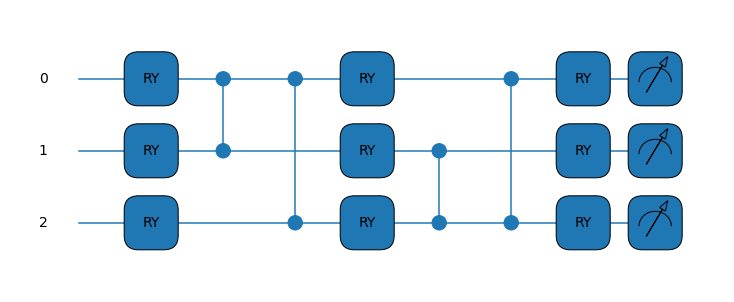

In [61]:
q = vqls_circuit.solution(weights, True, True)


## aosiegn


beta_classic                 : [ 0.01798621  0.07173906 -0.0502415   0.65973407 -0.0375285   1.14655868
  0.7277244   0.98201379]
{'gate_sizes': defaultdict(<class 'int'>, {1: 9, 2: 10}), 'gate_types': defaultdict(<class 'int'>, {'RY': 9, 'CZ': 4, 'Adjoint(CNOT)': 6}), 'num_operations': 19, 'num_observables': 1, 'num_diagonalizing_gates': 0, 'num_used_wires': 3, 'depth': 13, 'num_trainable_params': 9, 'num_device_wires': 3, 'device_name': 'default.qubit', 'expansion_strategy': 'gradient', 'gradient_options': {}, 'interface': 'autograd', 'diff_method': 'best', 'gradient_fn': 'pennylane.gradients.parameter_shift.param_shift', 'num_gradient_executions': 'NotSupported: Computing the gradient of circuits that return the state is not supported.'}
Quantum State [0.08348763+0.j 0.11363697+0.j 0.12454732+0.j 0.18836336+0.j
 0.29215869+0.j 0.45045094+0.j 0.48332467+0.j 0.63816783+0.j]


d:\conda\envs\res\lib\site-packages\pennylane\_qubit_device.py:776: UserWarning: Requested state or density matrix with finite shots; the returned state information is analytic and is unaffected by sampling. To silence this warning, set shots=None on the device.
  UserWarning,


(<Figure size 1152x288 with 1 Axes>, <Axes:>)
RSS_q: 2.5298634025126914
RSS_h: (0.4566396687307791+0j)


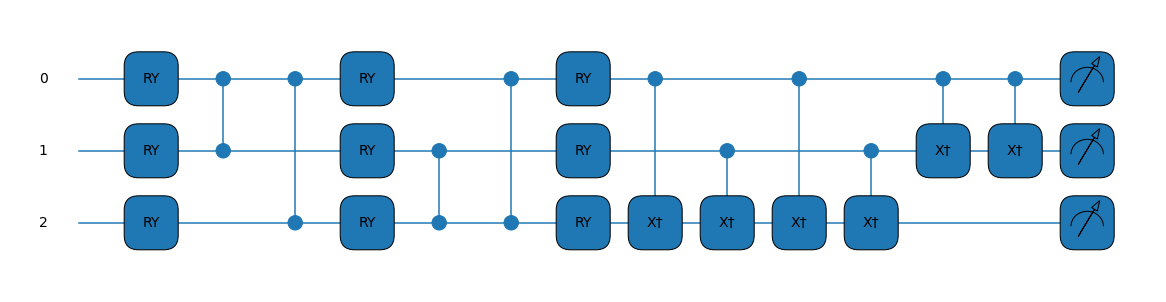

In [29]:
#Classic beta coefficients
c = np.linalg.solve(matrix,vector)
print('beta_classic                 :',c)
y_c=np.dot(matrix,c) #classic


y_q=np.dot(matrix,q) #hybrid
                     #Quantum
y_fq=[]
for el in matrix:
  y_fq.append(vqls_circuit.direct_prod2(weights,el,visualize=True))
  break
rss_full = np.sum(np.square(np.array(y_c) - np.array(y_fq)))
rss_hybr = np.sum(np.square(np.array(y_c) - np.array(y_q)))

print('RSS_q:',rss_full)
print('RSS_h:',rss_hybr)



In [17]:
len(y_fq)

8

d:\conda\envs\res\lib\site-packages\matplotlib\collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


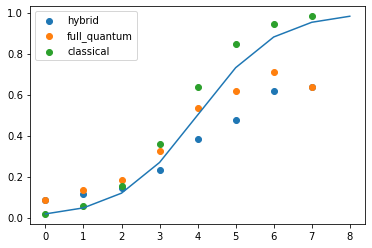

In [19]:
plt.scatter(range(len(y_fq)),y_q,label= "hybrid")
plt.scatter(range(len(y_fq)),y_fq, label="full_quantum")
plt.scatter(range(len(y_fq)),y_c, label="classical")
plt.plot(y)
plt.legend()